In [5]:
%run init_notebookspace.py
from settings import DATA_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\bayes_filter\data


In [86]:
import pandas as pd

from hmmlearn import hmm

import matplotlib.pyplot as plt

from src.pull_data import load_csv

In [152]:
df = load_csv(file_name='prices.csv', path=DATA_DIR).drop('Unnamed: 0', axis=1)

df["datetime"] = pd.to_datetime(df["date"])
df.rename(columns={'^GSPC': 'sp500'}, inplace=True)

df['sp500_rets'] = df['sp500'].diff()
df.dropna(inplace=True)

df = df.iloc[:-251]

In [198]:
def apply_intervals(x, interval_dict: dict, left_inclusive: bool = True):
    for key, item in interval_dict.items():
        if left_inclusive & (item[0] <= x < item[1]):
            return key
        elif left_inclusive & (item[0] < x <= item[1]):
            return key
        else:
            continue
            
    pass

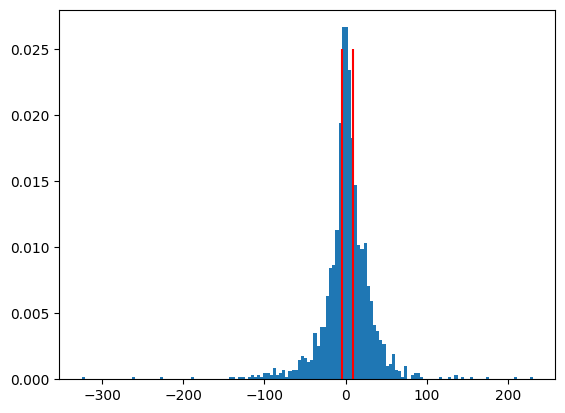

In [213]:
ser = df.sp500_rets.copy()
intervals = {
    0: [-1000000, ser.quantile(1/3)],
    1: [ser.quantile(1/3), ser.quantile(2/3)],
    2: [ser.quantile(2/3), 1000000]
}

plt.hist(ser, bins='fd', density=True);
plt.vlines(intervals[1][0], 0, .025, color='red');
plt.vlines(intervals[1][1], 0, .025, color='red');

df['sp500_regimes'] = df.sp500_rets.apply(lambda x: apply_intervals(x, intervals))
df['sp500_regimes_prev'] = df.sp500_regimes.shift(1)
df.dropna(inplace=True)

In [223]:
# state space
T = df.groupby(['sp500_regimes', 'sp500_regimes_prev'])['sp500_regimes'].count().unstack()
T.apply(lambda x: x / sum(x), axis=1)

sp500_regimes_prev,0.0,1.0,2.0
sp500_regimes,,,
0,0.319113,0.317406,0.363481
1,0.284497,0.396934,0.318569
2,0.394558,0.285714,0.319728


In [201]:
X = df[['sp500_rets']].values

# Build the HMM model and fit to the gold price change data.
mod = hmm.GaussianHMM(n_components = 3, covariance_type = "diag", n_iter = 50, random_state = 42)
mod.fit(X)

# Predict the hidden states corresponding to observed X.
Z = mod.predict(X)
states = pd.unique(Z)

C:\Users\LukasGrahl\Documents\GIT\bayes_filter\env_bayes_filter\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [202]:
states

array([2, 0, 1], dtype=int64)

In [203]:
model.startprob_

array([6.98887309e-01, 3.01112687e-01, 4.05579175e-09])

In [204]:
mod.transmat_

array([[3.15081720e-02, 9.68288862e-01, 2.02965955e-04],
       [8.25390710e-01, 1.30617243e-01, 4.39920467e-02],
       [3.08384036e-02, 2.49340433e-02, 9.44227553e-01]])

In [205]:
mod.means_

array([[ 0.52740862],
       [ 4.81045582],
       [-1.39685315]])

In [206]:
mod.covars_

array([[[ 128.81576892]],

       [[ 282.49435005]],

       [[2819.83968743]]])

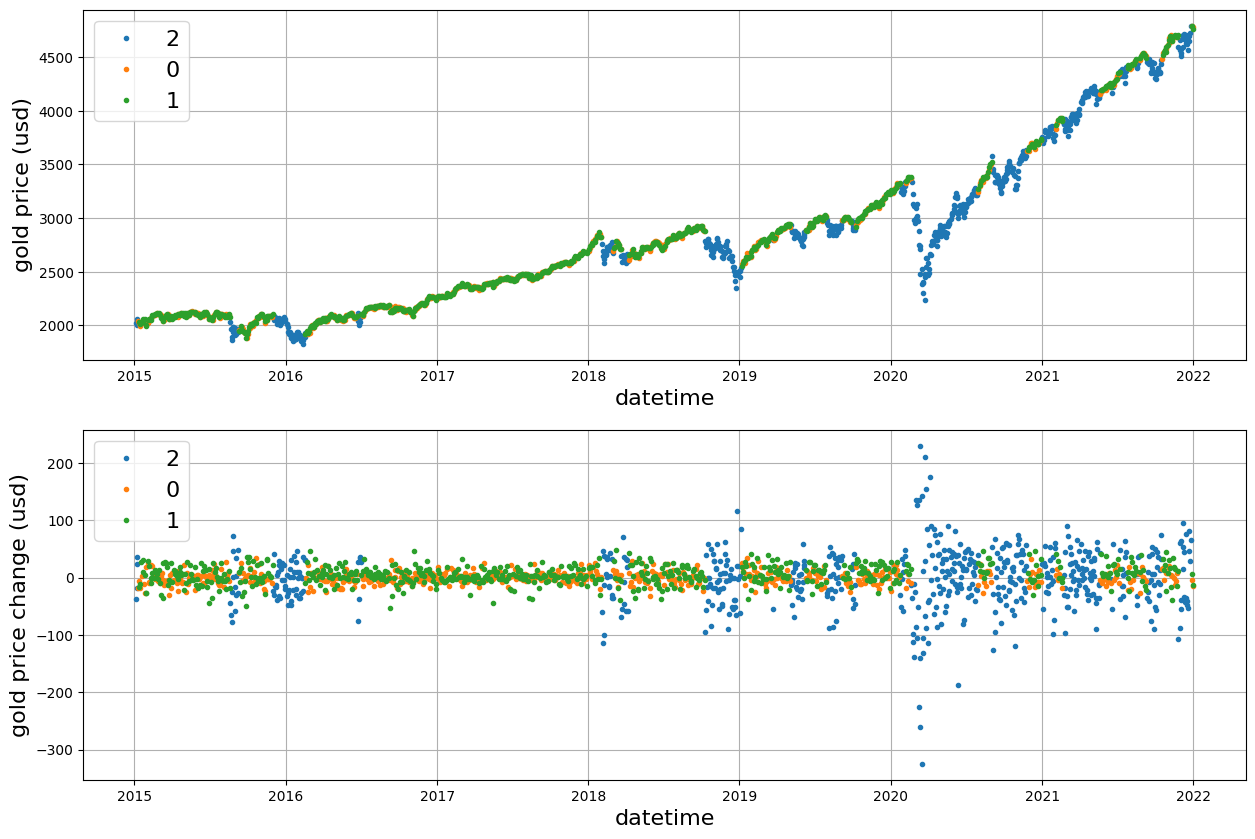

In [207]:
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in states:
    want = (Z == i)
    x = df["datetime"].iloc[want]
    y = df["sp500"].iloc[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price (usd)", fontsize=16)
plt.subplot(2,1,2)
for i in states:
    want = (Z == i)
    x = df["datetime"].iloc[want]
    y = df["sp500_rets"].iloc[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price change (usd)", fontsize=16)
plt.show()